# World Data League 2022

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.


## 🎯 Challenge
Predict Waste Production for its Reduction

## 👥 Authors
* Luís Ventura
* Pedro Leal
* José Sá

## 💻 Development
Start coding here! 🐱‍🏍

## 1.Import packages

In [14]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf 
import requests, zipfile
from io import BytesIO

from utils_bin_1 import utils

%load_ext autoreload
%autoreload 2

In [6]:
url = 'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'

filename = url.split('/')[-1]

# Sending request
req = requests.get(url)
print('Downloading Completed')

# Extracting the files to a folder "NewFolder"
zipfile= zipfile.ZipFile(BytesIO(req.content))
zipfile.extractall('/NewFolder')

## 2. Import data

We are importing data from the following sources:

1. data.austintexas.gov - Waste Collection Diversion Daily Report. For more details, see [here](https://data.austintexas.gov/Utilities-and-City-Services/Waste-Collection-Diversion-Report-daily-/mbnu-4wq9).
2. Google Mobility data for Travis county, where the city of Austin, see [here](https://www.google.com/covid19/mobility/). 

In [7]:
client = Socrata("data.austintexas.gov", "HiZUIIcbfnnM2H1drg0UUuD4Z") 

start_year = 2012

results = client.get("mbnu-4wq9", where= f"report_date BETWEEN '{start_year}-01-01' and '2021-12-31'", limit=1000000)

In [8]:
waste_collection_df = pd.DataFrame.from_records(results)

In [9]:
mobility_data_df_original = pd.read_csv('/NewFolder/2020_US_Region_Mobility_Report.csv')

In [89]:
mobility_data_df = mobility_data_df_original[mobility_data_df_original["sub_region_2"] == "Travis County"]\
[["date",	"retail_and_recreation_percent_change_from_baseline"\
  ,"grocery_and_pharmacy_percent_change_from_baseline"\
  ,"parks_percent_change_from_baseline"\
  ,	"transit_stations_percent_change_from_baseline"\
  ,	"workplaces_percent_change_from_baseline"\
  ,"residential_percent_change_from_baseline"]]

## 3. EDA

Summary of main conclusions per subsection:

1. **Austin waste DataFrame information: missing values and multiplicity**:

*   The missing values in *SWEEPING* might be due to the fact that sweeping load weights are too small to be reported.
*   The most relevant columns are *GARBAGE COLLECTIONS*, *YARD TRIMMING*, *RECYCLING - SINGLE STREAM*, *ORGANICS*.


2. **Generating time-series and checking the seasonality of the components**:

*   Several years appear to have maxima of the trash levels following the South by Southwest festival, which occurs during mid-March.
*   Yard trimming is quite a seasonal component as expected (as grass requires cutting during Spring).

3. **Evolution of the main waste components as a function of time as a percentage of total**:

*   During the past 10 years, the waste components have remained relatively constant. Disappontingly, there has not been an increased adoption of recycling.
*   On the other hand, composting (*ORGANICS*) has gained relevance recently as the city of Austin enacted policies incentivizing the use of household composting bins.

4. **What is the dropsite location of each type of waste?**

*   Undifferentiated garbage goes basically to one place, the TDS Landfill. See details of the waste processing [here](https://www.youtube.com/watch?v=5kC026ImtmA&ab_channel=TexasDisposalSystems).
*   Recycled products go to 3 main locations - Balcones, TDS - MRF (which was the most import point in 2012, but then lost relevance to Balcones) and TDS Landfill, where they also recycle.
* Yard trimming goes mosty to Hornsby Bend, with Organics by Gosh playing a more relevant role recently.

Although we have not use this information as an input for the model, we think that knowledge of the main collection centers - together with the most meaningful routes (point 5 below) - allows to better design the waste management routes, minimizing the carbon emissions of the waste management trucks.

5. **Analyzing Dropsite and what are the paths that contribute the most to the total**

### 1. DataFrame information: missing values, column multiplicity and largest waste contributors

In [11]:
waste_collection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411063 entries, 0 to 411062
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   report_date   411063 non-null  object
 1   load_type     411063 non-null  object
 2   load_time     411063 non-null  object
 3   load_weight   374246 non-null  object
 4   dropoff_site  411063 non-null  object
 5   route_type    411063 non-null  object
 6   route_number  411063 non-null  object
 7   load_id       411063 non-null  object
dtypes: object(8)
memory usage: 25.1+ MB


Some missing values in the load_weight column (see below), otherwise everything looks fine. Let us take a look at the mulitplicity of the columns:

In [12]:
for ele in ["load_type","dropoff_site","route_type","route_number"]:
  print(ele)
  print(waste_collection_df[ele].unique())
  print("\n")

load_type
['GARBAGE COLLECTIONS' 'RECYCLING - SINGLE STREAM' 'YARD TRIMMING'
 'DEAD ANIMAL' 'SWEEPING' 'BRUSH' 'BULK' 'TIRES' 'LITTER' 'MIXED LITTER'
 'RECYCLED METAL' 'MULCH' 'MATTRESS' 'BAGGED LITTER'
 'YARD TRIMMING - X-MAS TREES' 'ORGANICS' 'CONTAMINATED RECYCLING'
 'CONTAMINATED YARD TRIMMINGS' 'CONTAMINATED ORGANICS']


dropoff_site
['TDS LANDFILL' 'TDS - MRF' 'HORNSBY BEND' 'GREAT NORTHERN' 'ONION CREEK'
 'STEINER LANDFILL' 'BRAKER SITE' 'WILCAB' 'BURGER CENTER' 'ELMONT'
 'WESTFIELD' 'PARK CENTER' 'BALCONES RECYCLING' 'MRF' 'ZILKER'
 'BARTON SKYWAY' 'BALCONES WOODS' 'ORGANICS BY GOSH' 'ST. EDWARDS'
 'PEASE PARK' 'COMMERCIAL METALS' 'INSPIRATION/GUNNISAN' 'BFI LANDFILL'
 'ON ROUTE HIGH DUMP' 'LITTER DROPOFF' 'WINNEBAGO' 'AUSTIN WOOD RECYCLING'
 'AUSTIN IRON AND METAL' 'PARK BEND']


route_type
['GARBAGE COLLECTION' 'RECYCLING - SINGLE STREAM' 'YARD TRIMMINGS'
 'DEAD ANIMAL' 'STREET CLEANING-RESIDENTIAL' 'BRUSH'
 'STREET CLEANING-DOWNTOWN' 'INHOUSE - RECYCLING' 'BULK'
 'SPECIAL PR

Check where the missing values of load weight come from:

In [13]:
waste_collection_df.groupby(["load_type"]).agg({'load_weight': lambda x: x.isnull().sum()}).T

load_type,BAGGED LITTER,BRUSH,BULK,CONTAMINATED ORGANICS,CONTAMINATED RECYCLING,CONTAMINATED YARD TRIMMINGS,DEAD ANIMAL,GARBAGE COLLECTIONS,LITTER,MATTRESS,MIXED LITTER,MULCH,ORGANICS,RECYCLED METAL,RECYCLING - SINGLE STREAM,SWEEPING,TIRES,YARD TRIMMING,YARD TRIMMING - X-MAS TREES
load_weight,0,4,3,0,0,0,3,19,26,0,1,0,16,0,40,36674,17,13,1


The missing values in SWEEPING might be due to the fact that sweeping load weights are too small to be reported.

Transform report date into a Datetime object and sort the DataFrame per this column, adding a couple of assistance columns.

In [15]:
waste_collection_df['report_date'] = pd.to_datetime(waste_collection_df['report_date'])

In [18]:
waste_collection_ext_df = utils.creating_waste_features(waste_collection_df)

In [19]:
total_trash_df_cat = waste_collection_ext_df.groupby(['load_type','dropoff_site']).agg({'load_weight':"sum"})

total_trash_df = total_trash_df_cat.groupby('load_type').sum() ## Check https://en.wikipedia.org/wiki/Single-stream_recycling

Total amount of trash generated between '2012-01-01' and '2021-12-31':


In [20]:
tt_df = total_trash_df.T
tt_df

load_type,BAGGED LITTER,BRUSH,BULK,CONTAMINATED ORGANICS,CONTAMINATED RECYCLING,CONTAMINATED YARD TRIMMINGS,DEAD ANIMAL,GARBAGE COLLECTIONS,LITTER,MATTRESS,MIXED LITTER,MULCH,ORGANICS,RECYCLED METAL,RECYCLING - SINGLE STREAM,SWEEPING,TIRES,YARD TRIMMING,YARD TRIMMING - X-MAS TREES
load_weight,103940.0,135305914.0,190700437.0,25380.0,45600.0,3740.0,907521.0,2.498368e+09,3693610.0,29000.0,5100790.0,6221373.0,192513186.0,606170.0,1.110958e+09,91168780.0,3833429.0,473331103.0,127260.0


As we shall see below, garbage collection is the main source of waste in Austin. The second source of waste is single-stream recycling (all material to be recycled - paper, plastic, metal - is placed in a single container). This is a rather inefficient way of recyling because 1) it needs to be separated by a third part, 2) it often leads to items not being able to be recycled. The third one is yard trimming (which is not too surprising given American's predilection for large grassy yards). 

In the past few years, organics has been gaining relevance.

In [21]:
total_trash_df.nlargest(10, "load_weight")

,load_weight
load_type,
GARBAGE COLLECTIONS,2.498368e+09
RECYCLING - SINGLE STREAM,1.110958e+09
YARD TRIMMING,4.733311e+08
ORGANICS,1.925132e+08
BULK,1.907004e+08
BRUSH,1.353059e+08
SWEEPING,9.116878e+07
MULCH,6.221373e+06
MIXED LITTER,5.100790e+06


### 2. Generating time-series and checking the seasonality of the components


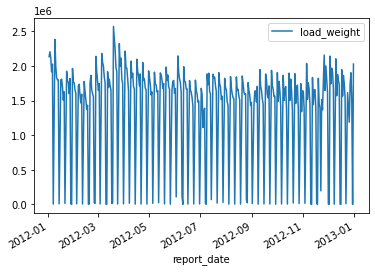

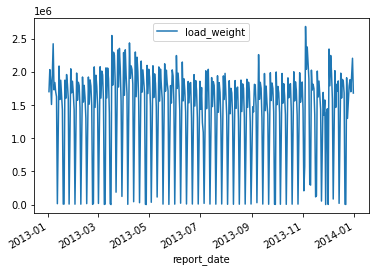

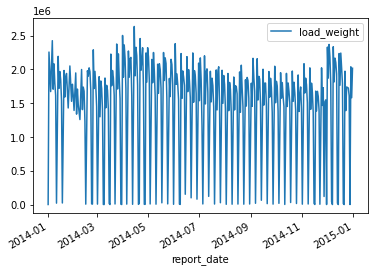

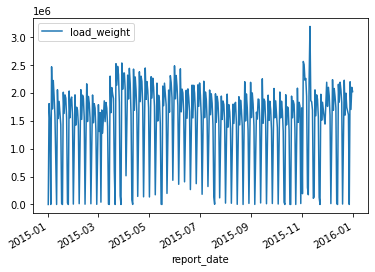

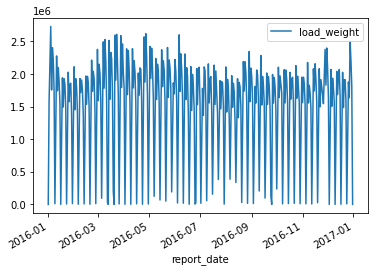

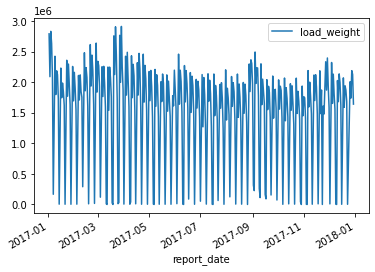

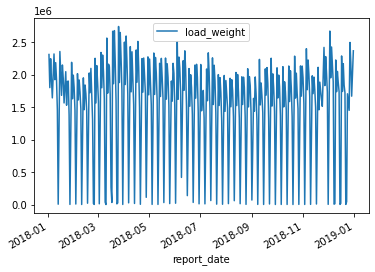

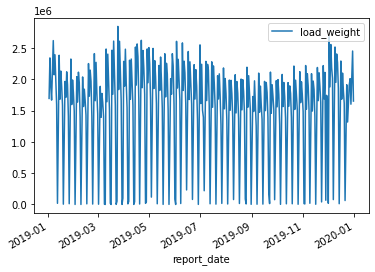

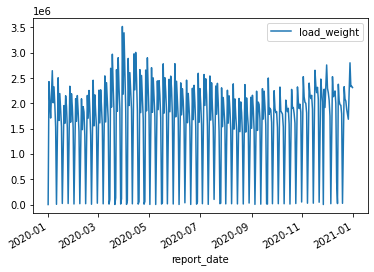

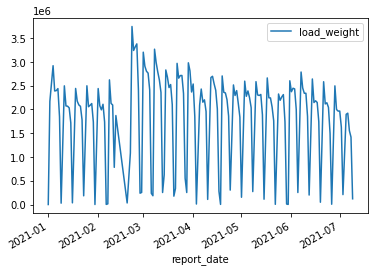

In [23]:
total_trash_year_dict , total_trash_year_cat_dict = utils.generating_waste_charts(waste_collection_ext_df)

The reason why July 2021 has a smaller total waste weight is because data stopped being collected in the 11th of July.

Some comments:
1. Most often, the peak of waste collection occurs at the end of March, beginning of April. **What is happening during these dates?** Could it be the famous festival, South by Southwest?
2. January has a local maximum - might be due to waste collection after NYE.
3. The amount of waste then decreases throughout Jan and Feb, reaches a max in March/April, them decreases throughout the rest of the year until we reach November/December. (People go on holidays, grass does not need to be cut?)

What about the seasonality of certain components?

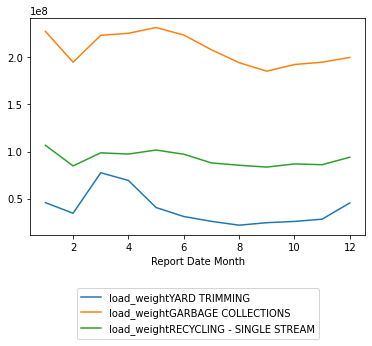

In [24]:
fig, ax = plt.subplots()

for load_type in ["YARD TRIMMING","GARBAGE COLLECTIONS", "RECYCLING - SINGLE STREAM"]:
    waste_collection_ext_df[(waste_collection_ext_df["Report Date Year"] >= start_year) & (waste_collection_ext_df['load_type'] == load_type)]\
        .groupby("Report Date Month")\
        .agg({'load_weight':"sum"})\
        .rename({'load_weight':'load_weight' + load_type}, axis = 1).plot(ax = ax)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol = 1)
plt.show()

As expected, yard trimming increases in the Spring months.

### 3. Evolution of the main waste components as a function of time as a percentage of total


In [26]:
trash_evolution_df = pd.concat(total_trash_year_dict.values())
trash_evolution_df_freq = trash_evolution_df.mul(1/trash_evolution_df.sum(axis = 1), axis = 0)

In [27]:
trashold = 0.02
trash_columns = trash_evolution_df_freq.mean()[(trash_evolution_df_freq.mean() > trashold)].index

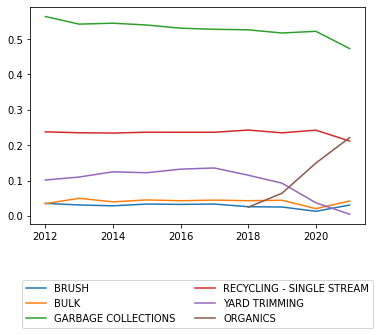

In [28]:
### Evolution of the trash composition as a function of time
trash_evolution_df_freq[trash_columns].plot()
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol = 2)
plt.show()


Unsuprisingly, regular garbage accounts for more than 50% of all the trash in Austin, whereas recycling is only about 25%. Note that both components have remained relatively steady throughout the years - showing how much progress there is to be done in waste management - with yard trimming (i.e, cut grass) decreasing since 2017.

The percentage of recycled waste and garbage collections decreased in 2021 - is this due to the fact that the big 6 above no longer account for most of the trash, or because there is change in the components? *See below the answer for these two questions.*

The increase in organics is due to a program from the city of Austin for [curbside composite collection](https://www.austintexas.gov/composting) that started in 2017 (maybe 2017 itself was not registered in the database, or it was under a different name). In 2021, the program was [expanded](https://www.austintexas.gov/news/city-expands-curbside-composting-collection-55000-new-austin-households-final-phase-expansion). Furthermore, [yard trimmings](https://www.austintexas.gov/department/yard-trimmings-collection) are now collected as part of this, which explains why their volume reduces dramatically from Feb 2021 onwards:

*The program collects food scraps, yard trimmings, food-soiled paper and natural fibers, and converts them into nutrient-rich compost. Because materials are processed in a commercial composting facility, extremely high temperatures are reached, allowing Austinites to compost items like meat, dairy, seafood and bones that typically cannot be composted in a backyard. This program is part of the City of Austin’s zero waste goal to divert 90 percent of materials from landfills by 2040.* 




In [29]:
trash_evolution_df_freq[trash_columns].sum(axis = 1) ## No change in volume from 2020 to 2021

2012    0.972860
2013    0.967505
2014    0.971814
2015    0.976787
2016    0.974545
2017    0.977526
2018    0.977284
2019    0.977874
2020    0.984016
2021    0.983409
dtype: float64

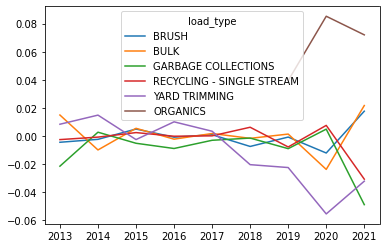



If these components are a closed system, then the overall change per year should sum to zero?
2012    0.000000
2013   -0.005355
2014    0.004309
2015    0.004973
2016   -0.002242
2017    0.002981
2018   -0.024909
2019    0.000590
2020    0.006142
2021   -0.000607
dtype: float64


In [30]:
trash_evolution_df_freq[trash_columns].diff().plot()
plt.show() 
print("\n")
print("If these components are a closed system, then the overall change per year should sum to zero?")
print(trash_evolution_df_freq[trash_columns].diff().sum(axis = 1))

Indeed, the 6 main components described above account for most of the waste, thereby generating an almost closed system, where changes in one of the components is accounted for another/several components in the big 6. 

In [31]:
trash_evolution_df_freq[["GARBAGE COLLECTIONS","ORGANICS","YARD TRIMMING"]].diff().sum(axis = 1)

2012    0.000000
2013   -0.013167
2014    0.017509
2015   -0.007785
2016    0.001125
2017    0.000277
2018   -0.021931
2019    0.007884
2020    0.034570
2021   -0.009124
dtype: float64

In 2021, the decrease in yard trimming and garbage collections was basically due to the increase in organics.

### 4. What is the dropsite location of each type of waste?

In [32]:
### Understand the final location of each type of trash
main_trash_df_cat = total_trash_df_cat.loc[trash_columns]
main_trash_df_cat_freq = main_trash_df_cat/main_trash_df_cat.sum(axis = 0).values

In [33]:
main_cont_list = ["GARBAGE COLLECTIONS","RECYCLING - SINGLE STREAM","YARD TRIMMING"]
main_comp_df_freq = main_trash_df_cat_freq.loc[main_cont_list]

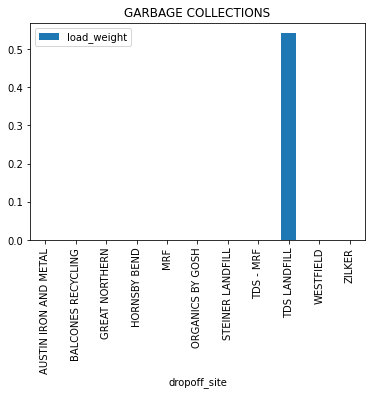

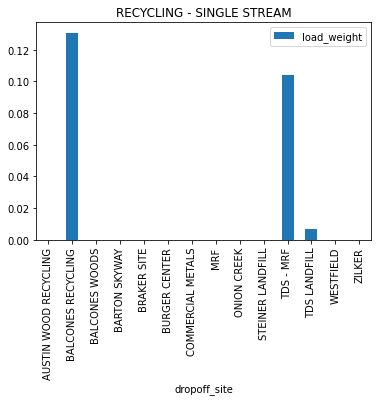

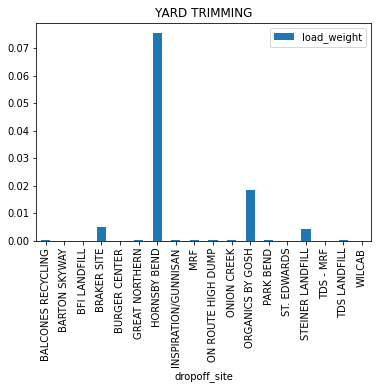

In [34]:
for ele in main_comp_df_freq.index.get_level_values(0).unique():
    main_comp_df_freq.loc[ele,:].plot(kind = "bar", title = ele)

In [35]:
extra_dic = {}

for key in total_trash_year_cat_dict.keys():

    trash_cat_df_year = total_trash_year_cat_dict[key].loc[main_cont_list,:]/total_trash_year_cat_dict[key].sum().values[0]
    trash_cat_df_year.columns = [trash_cat_df_year.columns[0] + str(key)]

    print(f"For the year of {key}, the 3 components above contribute:")
    print(trash_cat_df_year.groupby('load_type').sum())
    total_waste = trash_cat_df_year.groupby('load_type').sum().sum().values[0]
    print(f"That is, about {total_waste} of the total")
    print("\n")

    extra_dic[key] = trash_cat_df_year

For the year of 2012, the 3 components above contribute:
                           load_weight2012
load_type                                 
GARBAGE COLLECTIONS               0.563417
RECYCLING - SINGLE STREAM         0.237599
YARD TRIMMING                     0.101501
That is, about 0.9025162407355652 of the total


For the year of 2013, the 3 components above contribute:
                           load_weight2013
load_type                                 
GARBAGE COLLECTIONS               0.541908
RECYCLING - SINGLE STREAM         0.235004
YARD TRIMMING                     0.109842
That is, about 0.8867542073744618 of the total


For the year of 2014, the 3 components above contribute:
                           load_weight2014
load_type                                 
GARBAGE COLLECTIONS               0.544586
RECYCLING - SINGLE STREAM         0.234177
YARD TRIMMING                     0.124674
That is, about 0.9034362405423068 of the total


For the year of 2015, the 3 component

Waste per destination in more detail as a function of time:

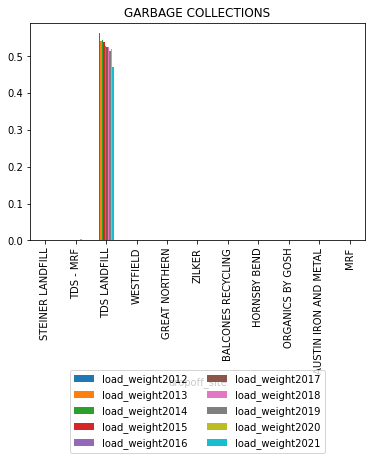

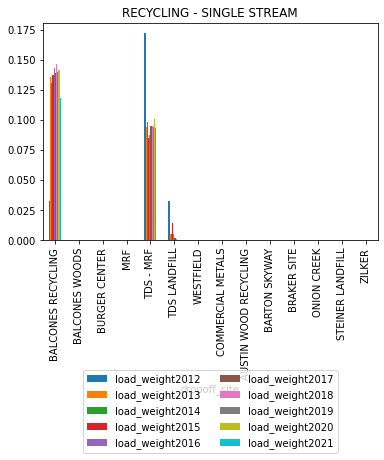

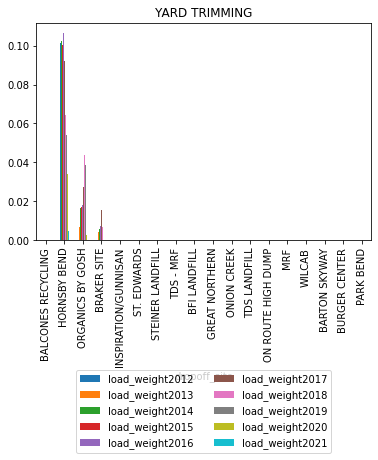

In [36]:
start_df = list(extra_dic.values())[0]

for table in list(extra_dic.values())[1:]:
    start_df = pd.merge(start_df, table, on = ['load_type','dropoff_site'], how = "outer")

for ele in main_cont_list:
    start_df.loc[ele].plot(kind = "bar",title = ele)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -1), ncol = 2)
    plt.show()

Conclusions from the charts above:
1. Undifferentiated garbage goes basically to one place, the TDS Landfill;
2. Recycled products go to 3 main locations - Balcones, TDS - MRF (which was the most import point in 2012, but then lost relevance to Balcones) and TDS Landfill (where I think they also recycle);
3. Yard trimming goes mosty to Hornsby Bend, with Organics by Gosh playing a more relevant role recently;

### 5. Analyzing Dropsite and what are the paths that contribute the most to the total

In [37]:
waste_collection_ext_df["dropoff_site"].unique()

array(['TDS LANDFILL', 'TDS - MRF', 'HORNSBY BEND', 'ONION CREEK',
       'GREAT NORTHERN', 'STEINER LANDFILL', 'BRAKER SITE', 'WILCAB',
       'BURGER CENTER', 'ELMONT', 'PARK CENTER', 'WESTFIELD',
       'BALCONES RECYCLING', 'MRF', 'ZILKER', 'BARTON SKYWAY',
       'BALCONES WOODS', 'ORGANICS BY GOSH', 'ST. EDWARDS', 'PEASE PARK',
       'COMMERCIAL METALS', 'INSPIRATION/GUNNISAN', 'BFI LANDFILL',
       'ON ROUTE HIGH DUMP', 'LITTER DROPOFF', 'WINNEBAGO',
       'AUSTIN WOOD RECYCLING', 'AUSTIN IRON AND METAL', 'PARK BEND'],
      dtype=object)

In [38]:
waste_collection_ext_df["load_type"].unique()

array(['GARBAGE COLLECTIONS', 'RECYCLING - SINGLE STREAM',
       'YARD TRIMMING', 'DEAD ANIMAL', 'BRUSH', 'SWEEPING', 'BULK',
       'TIRES', 'LITTER', 'MIXED LITTER', 'RECYCLED METAL', 'MULCH',
       'MATTRESS', 'BAGGED LITTER', 'YARD TRIMMING - X-MAS TREES',
       'ORGANICS', 'CONTAMINATED RECYCLING',
       'CONTAMINATED YARD TRIMMINGS', 'CONTAMINATED ORGANICS'],
      dtype=object)

Checking what are the paths that most contribute to the overall amount of garbage.

In [39]:
df_trash_per_loc = waste_collection_ext_df.groupby(["load_type","dropoff_site","route_number"]).agg({"load_weight": "sum"})

In [40]:
df_trash_per_loc_GC = df_trash_per_loc.loc["GARBAGE COLLECTIONS"]/df_trash_per_loc.loc["GARBAGE COLLECTIONS"].sum() #/df_trash_per_loc.loc["GARBAGE COLLECTIONS"].groupby("dropoff_site").sum()

In [41]:
df_trash_per_loc_GC.max()

load_weight    0.007736
dtype: float64

In [42]:
df_GC_tds = df_trash_per_loc_GC[df_trash_per_loc_GC > 0.001].dropna().sort_values(by = "load_weight", ascending  = False)

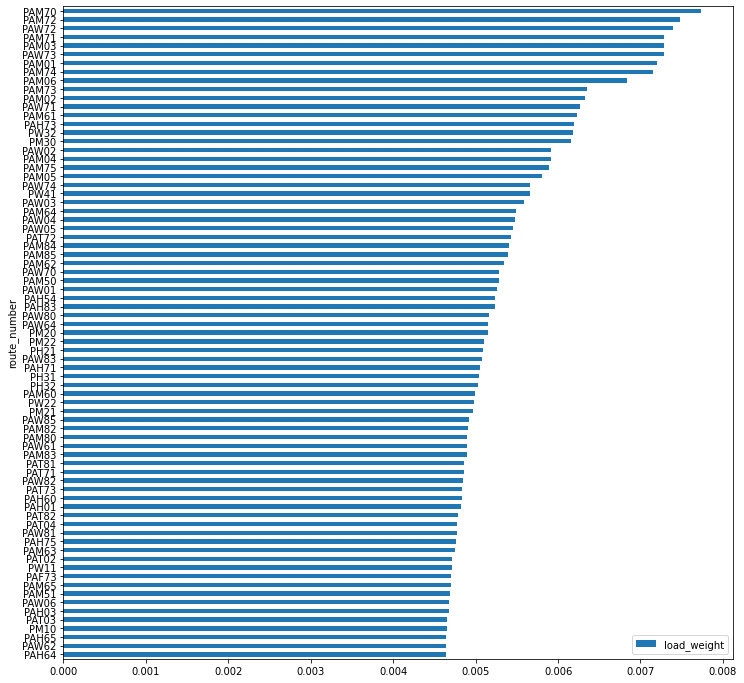

In [43]:
fig , ax = plt.subplots(figsize = (12,12))
df_GC_tds.droplevel(0)[:75].sort_values("load_weight", ascending = True).plot(kind = "barh", ax = ax)
plt.show()

Interestingly, several of the most meaningful paths are labelled with PAM or PAW.

## 4. Waste time-series analysis


Summary of main conclusions per subsection:

1. **Displaying the time-series for the most meaningful waste components**;
2. **Modeling the *garbage collection* component using *Statsmodels UnobservedComponents***;
  

*   Determining time-series seasonality by using ACF and PACF;
*   Using *UnobservedComponent* time-series model to fit the data. **Main conclusions**:

> 1. Apart from the lag 1 autoregressive coefficients, the others are not statistically significant. It therefore seems like the model is overfitting the data.


> 2. At a 5% confidence level, we cannot reject the null that the residuals are heteroskedastic.


> 3. At a 5% confidence level, we cannot reject the null that the residuals are normal. The distribution of residuals however appears to be bimodal and has a kurtosis significantly different from 3 - although with such a small number of points it is hard to be very confident in the tests.

> 4. The null hypothesis that there is no serial correlation of the residuals (Ljung-Box Q statistic) is rejected at ~1% CL (it is actually lower). This means that the specifying 1 single lag for the autocorrelation is not sufficient, we would likely need more lags to soak up the autocorrelation. *This can be also seen below when we study the ACF and PACF of the residuals.*



> 5. We have created a model that can generate a monthly forecast of the amount of waste. However, we stress that out-of-sample performance needs to be assessed. Furthermore, the lack of statistical significance of the coefficients is, in our view, troublesome.




3. **Modeling using *Statsmodels SeasonalDecompose***. This is not a fundamental model as above, instead using moving average to fit the data. Therefore, it does not provide a great deal of insight with respect to the data generating process. Nevertheless, it is useful as a benchmark and to understand some features of the model:

*   It appears that, as in the previous model, the level (trend) increases and decreases. We have investigated if this could be due to the business cycle by comparing the time-series with an leading indicator of [economic activity](https://data.oecd.org/leadind/composite-leading-indicator-cli.htm), but the results were inconclusive.
*   There appears to be a lag (of a few months) between the garbage collection and recycling trends.

* The seasonalities of both waste components are similar, however recycling has a larger peak at the end of the year, likely due to the Christmas gifts wrappings/boxes.

Finally, conclusions from comparing the two models:

*   The decomposition performs quite well when fitting the data (more so than the model). This is because the former is better able to capture the amplitude of the seasonal pattern.
*   Nevertheless, using mean squared error as a metric, our first model gets quite close.




### 1. Displaying the time-series for the most meaningful waste components

In [44]:
df3 = waste_collection_ext_df.pivot(columns = "load_type", values = "load_weight")
df3.index = waste_collection_df["report_date"]

In [45]:
season_trash_df = df3.resample("M").sum()

[]

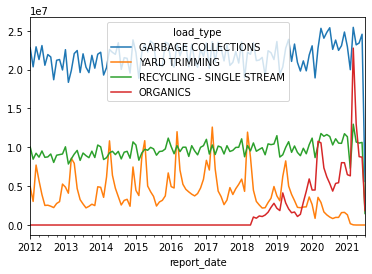

In [46]:
season_trash_df[["GARBAGE COLLECTIONS","YARD TRIMMING","RECYCLING - SINGLE STREAM","ORGANICS"]].plot()
plt.plot()

In [47]:
season_trash_df["YARD TRIMMING"][-20:]

report_date
2019-12-31    3611120.0
2020-01-31    2634280.0
2020-02-29     859260.0
2020-03-31    3558660.0
2020-04-30    2909020.0
2020-05-31    1685020.0
2020-06-30    1302500.0
2020-07-31    1023840.0
2020-08-31     831560.0
2020-09-30     979000.0
2020-10-31     977440.0
2020-11-30    1595460.0
2020-12-31    1626880.0
2021-01-31    1315500.0
2021-02-28     168560.0
2021-03-31      20460.0
2021-04-30          0.0
2021-05-31          0.0
2021-06-30          0.0
2021-07-31          0.0
Freq: M, Name: YARD TRIMMING, dtype: float64

Yard trimmngs disappeared because these started being accounted for in "Organics".

Let us plot organics plus yard trimming together - remember that organics starts in 2018:



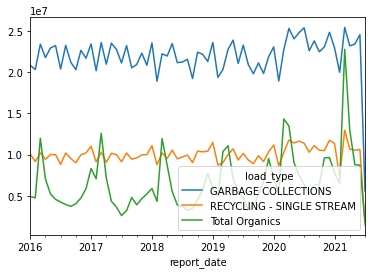

In [49]:
season_trash_df["Total Organics"] = season_trash_df["YARD TRIMMING"] + season_trash_df["ORGANICS"]
season_trash_df[["GARBAGE COLLECTIONS","RECYCLING - SINGLE STREAM", "Total Organics"]]['2016-01':].plot()
plt.show()

We decided not to model the total organics component - even though it has an interesting seasonal patter - because the classification of the data changed (see above), making it harder to forecast.

### 2. Modeling the *garbage collection* component using *Statsmodels UnobservedComponents*

Let us try to model a normalized version of the garbage time series:

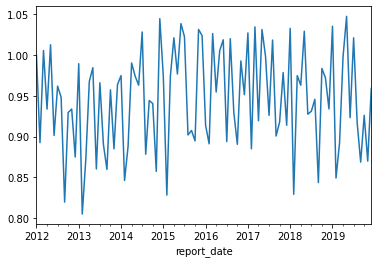

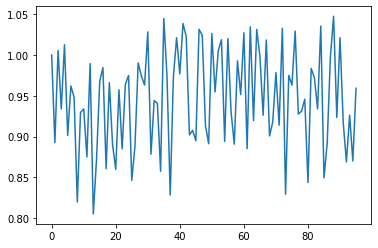

In [50]:
start_date_model = '01-2012'
end_date_model = '12-2019'

reference_val = season_trash_df["GARBAGE COLLECTIONS"][start_date_model].values[0]

norm_time_series = season_trash_df["GARBAGE COLLECTIONS"][start_date_model:end_date_model]/reference_val
norm_time_series_full = season_trash_df["GARBAGE COLLECTIONS"][start_date_model:]/reference_val

norm_time_series.plot()
plt.show()

time_index_y1 = norm_time_series.index
y1 = norm_time_series.values
x1 = range(0,len(y1))
plt.plot(y1)
plt.show()

There is a periodic structure to the time-series. Let us use autocorrelation and partial autocorrelation to determine the lags:

[14 10 13 12  0]
[ 6 19 15 12  0]


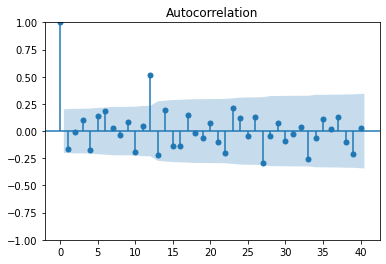

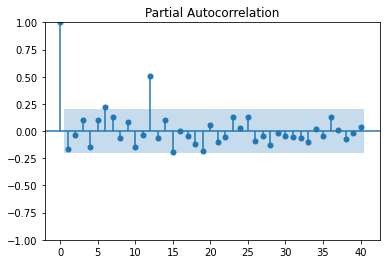

In [52]:
acf_coefs, acf_conf_int = acf(y1, alpha = 0.05)
pacf_coefs, pacf_conf_int = pacf(y1, alpha = 0.05)

print(np.abs(acf_coefs).argsort()[-5:])
print(np.abs(pacf_coefs).argsort()[-5:])

plot_acf(y1, lags = 40)
plt.show()
plot_pacf(y1, lags = 40, method='ywm')
plt.show()

As expected, there is a 12 month seasonality in the data. There might also be a second autocorrelation effect a period of 36 months, but it is not obvious to us what physical effect this might be.

Trying a statsmodels UnobservedComponents model:

                                Unobserved Components Results                                
Dep. Variable:                                     y   No. Observations:                   96
Model:              local linear deterministic trend   Log Likelihood                 120.920
                   + stochastic freq_seasonal(12(3))   AIC                           -231.839
                                             + AR(1)   BIC                           -219.452
Date:                               Sat, 07 May 2022   HQIC                          -226.849
Time:                                       21:43:04                                         
Sample:                                            0                                         
                                                - 96                                         
Covariance Type:                                 opg                                         
                                 coef    std err          z 

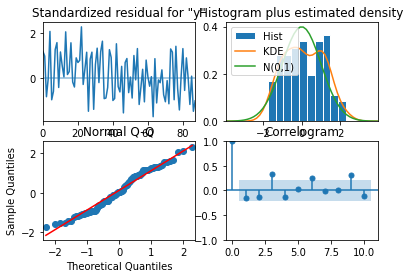

/root/anaconda3/envs/VirtEnvWDL2/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/root/anaconda3/envs/VirtEnvWDL2/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/root/anaconda3/envs/VirtEnvWDL2/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


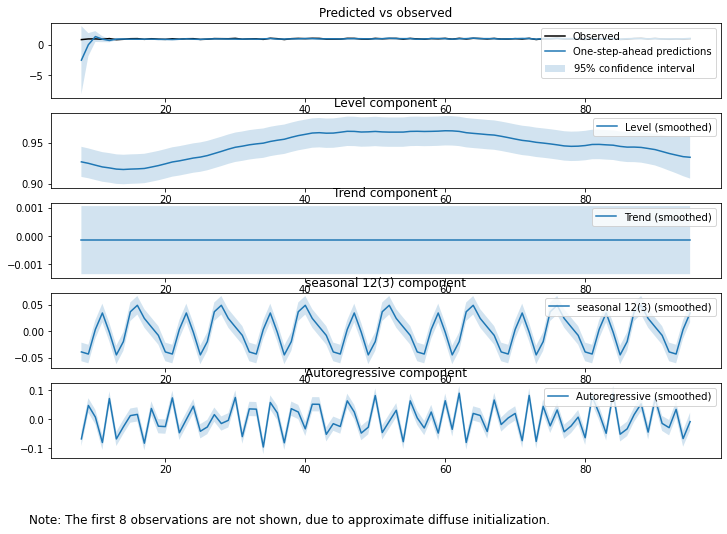

In [53]:
model = sm.tsa.UnobservedComponents(y1,
                                    trend = False,
                                    level ="lldtrend", #"fixed slope"
                                    freq_seasonal=[{'period': 12,
                                                    'harmonics': 3}],
                                   irregular = False,
                                   autoregressive = 1,
                                    stochastic_seasonal=True)

res_f = model.fit(disp=False)
print(res_f.summary())


res_f.plot_diagnostics()
plt.show()

res_f.plot_components(figsize = (12,8))
plt.show()

Conclusions:
1. Apart from the lag 1 autoregressive coefficients, the others are not statistically significant. It therefore seems like the model is overfitting the data.
2. The null hypothesis of no heteroskedasticity (i.e, their variance is not constant) is rejected at the 39% confidence level (CL). This means that, at a 5% confidence level, we cannot reject the null. 
3. The null hypothesis of normality is rejected at the 15% confidence level. This is also clear from the fact that the distribution of residuals appears to be bimodal and has a kurtosis significantly different from 3 - although with such a small number of points it is hard to be very confident in the tests.
4. The null hypothesis that there is no serial correlation of the residuals (Ljung-Box Q statistic) is rejected at ~1% CL (it is actually lower). This means that the specifying 1 single lag for the autocorrelation is not sufficient, we would likely need more lags to soak up the autocorrelation. *This can be also seen below when we study the ACF and PACF of the residuals.*

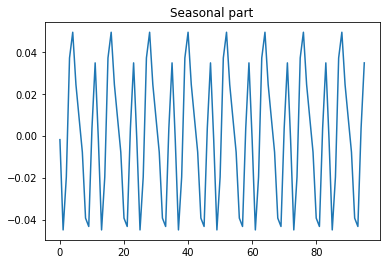

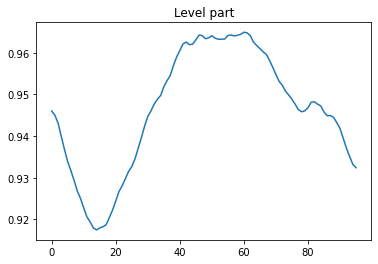

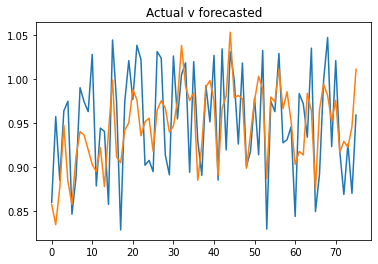

In [54]:
plt.plot(res_f.freq_seasonal[0]["smoothed"])
plt.title("Seasonal part")
plt.show()

plt.plot(res_f.level["smoothed"])
plt.title("Level part")
plt.show()

plt.plot(y1[20:])
plt.plot(res_f.forecasts[0][20:])
plt.title("Actual v forecasted")
plt.show()

The level is changing with time - **I wonder if this is due to the business cycle** (see below). As for the seasonal pattern, it looks like we are capturing the peaks and valleys, although the amplitude is lower than actual.

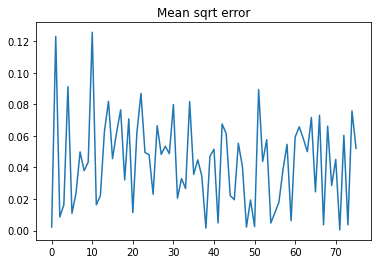

The mean sqrt error of the model above is 0.052


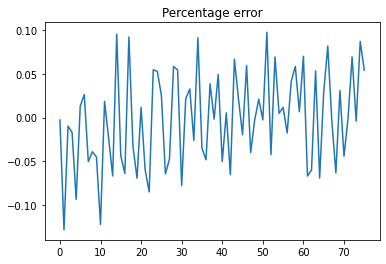

In [55]:
sq_error = (res_f.forecasts[0][20:] - y1[20:])**2
plt.plot(np.sqrt(sq_error))
plt.title("Mean sqrt error")
plt.show()

print(f"The mean sqrt error of the model above is {round(np.sqrt(np.mean(sq_error)), 3)}")

percent_error = (res_f.forecasts[0][20:] - y1[20:])/y1[20:]
plt.plot(percent_error)
plt.title("Percentage error")
plt.show()

The model undershoots at the start of the sample and overshoots at the end of the sample.

Let us check the residuals correlation structure:

In [56]:
y_resd = res_f.forecasts[0][20:] - y1[20:]

[14  9  3 13  0]
[14  3  9 13  0]


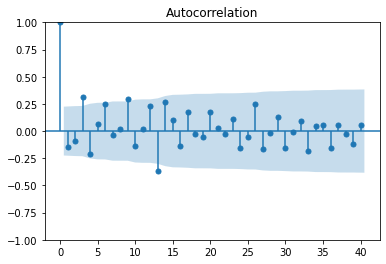

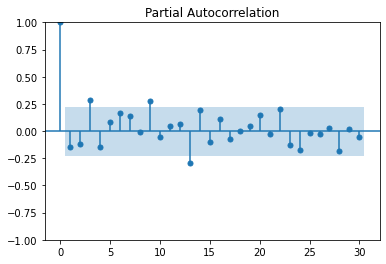

In [57]:
acf_coefs, acf_conf_int = acf(y_resd, alpha = 0.05)
pacf_coefs, pacf_conf_int = pacf(y_resd, alpha = 0.05)

print(np.abs(acf_coefs).argsort()[-5:])
print(np.abs(pacf_coefs).argsort()[-5:])

plot_acf(y_resd, lags = 40)
plt.show()
plot_pacf(y_resd, lags = 30, method = 'ywm')
plt.show()

Including an autoregressive component removes the autocorrelation at lag 1 in the residuals and improves the overall fit of the model, but at the expense of statistically insignificant coefficients. 

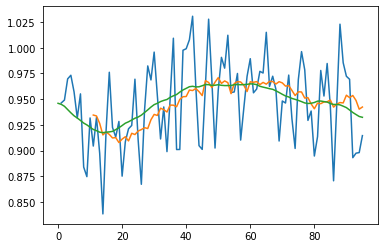

In [58]:
plt.plot(norm_time_series.rolling(+2).mean().values)
plt.plot(norm_time_series.rolling(+12).mean().values)
plt.plot(res_f.level["smoothed"])
plt.show()

It seems like we are at least roughly capturing the evolution of the waste level. With this model, we can now generate forecasts:

In [59]:
n_steps = 12
x_range = [i for i in range(0,n_steps)]

mean_pred = res_f.get_forecast(n_steps).predicted_mean

confidence_interval_95 = res_f.get_forecast(n_steps).conf_int(0.95)

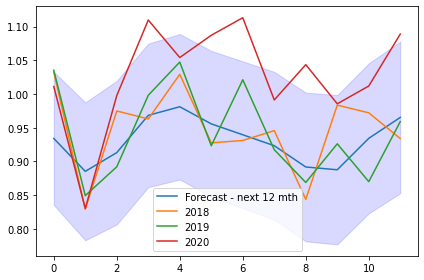

In [60]:
fig, ax = plt.subplots()

ax.plot(mean_pred, label = 'Forecast - next 12 mth')
ax.fill_between(x_range, confidence_interval_95[:,0], confidence_interval_95[:,1], color = "blue", alpha = 0.15)

ax.plot(norm_time_series_full['01-2018':'12-2018'].values, label = '2018')
ax.plot(norm_time_series_full['01-2019':'12-2019'].values, label = '2019')
ax.plot(norm_time_series_full['01-2020':'12-2020'].values, label = '2020')

plt.legend()
fig.tight_layout()
plt.show()

Main conclusion: As it is usual with time-series forecasting, the model has less variation (amplitude-wise) than the actual time series, but it does seem to capture the periodicity of the data. 

An extra necessary step to validate the model would be to test it out-of-sample, by comparing its predictions with 2020 and 2021 (which we have not done).

### 3. Modeling using *Statsmodels SeasonalDecompose*

Summary of the main conclusions:

*   The decomposition performs quite well when fitting the data (more so than the model). This is because the former is better able to capture the amplitude of the seasonal pattern.
*   Nevertheless, using mean squared error as a metric, our model gets quite close.

Decomposing the time-series into trend, seasonality and residual using moving averages.

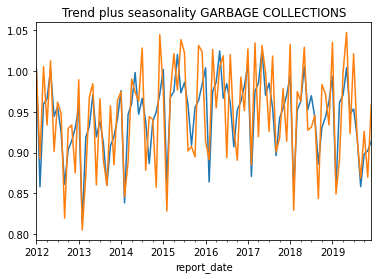

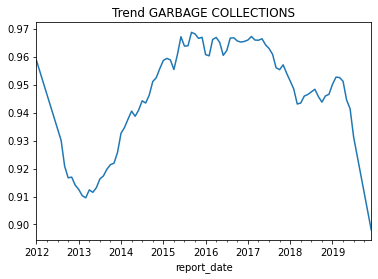

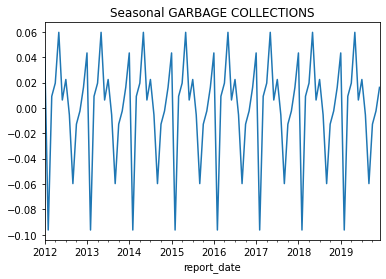

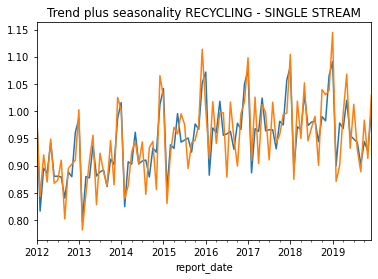

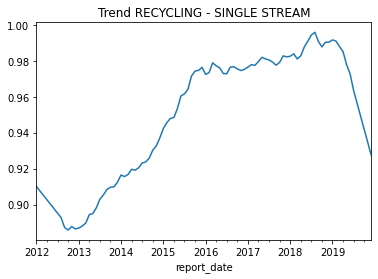

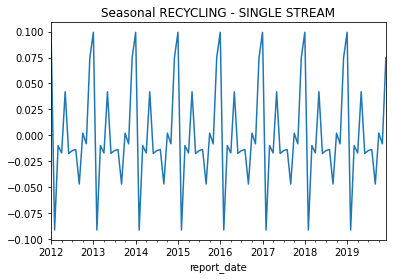

In [62]:
s_decomp_ts_dic = {}

for series_choice in ["GARBAGE COLLECTIONS","RECYCLING - SINGLE STREAM"]:
  gc_time_series = season_trash_df[series_choice][start_date_model:end_date_model]/season_trash_df[series_choice][start_date_model][0]
  s_decomp_ts = seasonal_decompose(gc_time_series, model = "additive", period = 12, two_sided = True, extrapolate_trend = True)

  s_decomp_ts_dic[series_choice] = s_decomp_ts

  (s_decomp_ts.trend + s_decomp_ts.seasonal).plot()
  gc_time_series.plot()
  plt.title(f"Trend plus seasonality {series_choice}")
  plt.show()
  
  s_decomp_ts.trend.plot()
  plt.title(f"Trend {series_choice}")
  plt.show()

  s_decomp_ts.seasonal.plot()
  plt.title(f"Seasonal {series_choice}")
  plt.show()


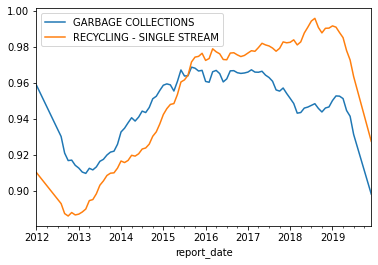

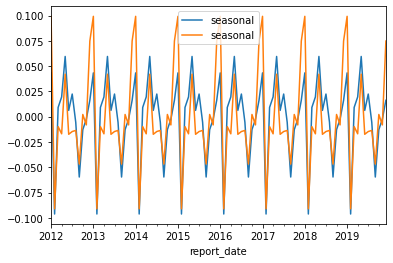

In [63]:
for key in s_decomp_ts_dic.keys():
  (s_decomp_ts_dic[key].trend).plot(label = key)
  plt.legend()
plt.show()

for key in s_decomp_ts_dic.keys():
  s_decomp_ts_dic[key].seasonal.plot()
  plt.legend()
plt.show()

Conclusions:


*   It appears that, as in the previous model, the level (trend) increases and decreases. We have investigated if this could be due to the business cycle by comparing the time-series with an leading indicator of [economic activity](https://data.oecd.org/leadind/composite-leading-indicator-cli.htm), but the results were inconclusive.
*   There appears to be a lag (of a few months) between the garbage collection and recycling trends.

* The seasonalities of both waste components are similar, however recycling has a larger peak at the end of the year, likely due to the Christmas gifts wrappings/boxes.



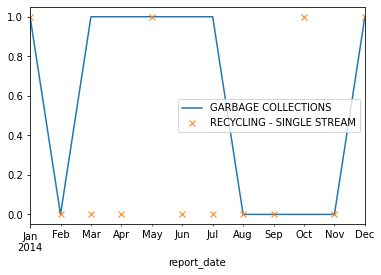

In [64]:
(s_decomp_ts_dic['GARBAGE COLLECTIONS'].seasonal > 0)\
    .astype("int64")['01-2014':'12-2014']\
    .plot()
(s_decomp_ts_dic['RECYCLING - SINGLE STREAM'].seasonal > 0)\
    .astype("int64")['01-2014':'12-2014']\
    .plot(linestyle = 'None', marker = 'x')
plt.legend(['GARBAGE COLLECTIONS', 'RECYCLING - SINGLE STREAM'])
plt.show()

The spring and summer months are those that generate the most trash (i.e, positive seasonality) - except for August (maybe people are on vacation). In December, there is a tick up probably due to Christmas, which is followed up in Jan (NYE?).

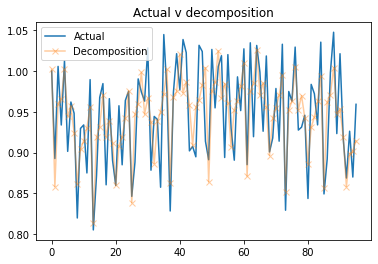

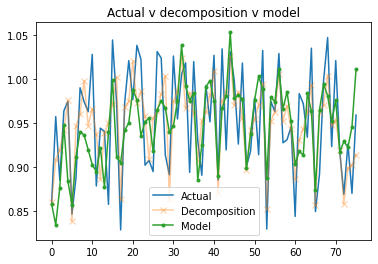

In [65]:
y1_dec_trend = (s_decomp_ts_dic['GARBAGE COLLECTIONS'].trend).values
y1_dec_season = (s_decomp_ts_dic['GARBAGE COLLECTIONS'].seasonal).values
y1_dec = (y1_dec_trend + y1_dec_season)

plt.plot(y1, color = 'tab:blue')
plt.plot(y1_dec, color = 'tab:orange', alpha = 0.4, marker ="x")
plt.legend(["Actual","Decomposition"])
plt.title("Actual v decomposition")
plt.show()

plt.plot(y1[20:])
plt.plot(y1_dec[20:], color = 'tab:orange', alpha = 0.4, marker ="x")
plt.plot(res_f.forecasts[0][20:], color = 'tab:green', marker = '.')
plt.legend(["Actual", "Decomposition", "Model"])
plt.title("Actual v decomposition v model")
plt.show()

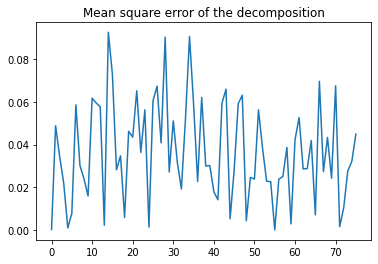

The mean sqrt error of the model above is 0.052
The mean sqrt error of the decomposition above is 0.043


In [66]:
sq_error_2 = (y1_dec[20:]- y1[20:])**2
plt.plot(np.sqrt(sq_error_2))
plt.title("Mean square error of the decomposition")
plt.show()

print(f"The mean sqrt error of the model above is {round(np.sqrt(np.mean(sq_error)), 3)}")
print(f"The mean sqrt error of the decomposition above is {round(np.sqrt(np.mean(sq_error_2)), 3)}")

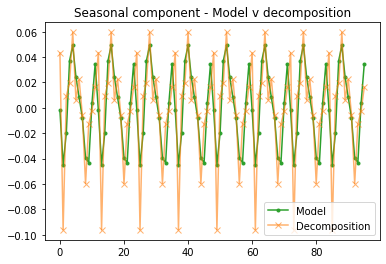

In [54]:
plt.plot(res_f.freq_seasonal[0]["smoothed"], color = 'tab:green', marker = '.')
plt.plot(y1_dec_season, color = 'tab:orange', alpha = 0.6, marker ="x")
plt.legend(["Model","Decomposition"])
plt.title("Seasonal component - Model v decomposition")
plt.show()

Conclusions from comparing the two models:

*   The decomposition performs quite well when fitting the data (more so than the model). This is because the former is better able to capture the amplitude of the seasonal pattern.
*   Nevertheless, using mean squared error as a metric, our model gets quite close.





## 5. COVID effect - Google Mobility data

Summary of main conclusions : 

**The reduction in retail/services mobility occurs simultaneously with an increase in residential mobility and an amount of waste compared to 2019.** This can be explained by a change in consumption patterns.

Let us now analyze the mobility data and compare this with the increase in waste volume in 2020 to check our hypothesis that consumption changed from goods and services to mainly goods. This should lead to a general increase in waste throughout 2020. 

Furthermore, since good consumption shifted from buying in physical stores to online shopping, we expect the amount of recycled waste to have increased even more given the increase in waste generated from mailed packages (cardboard boxes, plastic bags, styrofoam protective packages, etc...).

In [67]:
mobility_data_df['date'] = pd.to_datetime(mobility_data_df['date'])

In [69]:
mob_data_ss_df = mobility_data_df[["date",\
    "retail_and_recreation_percent_change_from_baseline",\
    "grocery_and_pharmacy_percent_change_from_baseline",\
    "parks_percent_change_from_baseline",\
    "transit_stations_percent_change_from_baseline",\
    "workplaces_percent_change_from_baseline",\
    "residential_percent_change_from_baseline"]].set_index("date")

In [70]:
m_highlights_df = mob_data_ss_df[["retail_and_recreation_percent_change_from_baseline",\
    "residential_percent_change_from_baseline",\
    "grocery_and_pharmacy_percent_change_from_baseline",\
    "parks_percent_change_from_baseline"]]

In [71]:
m_highlights_df.index.freq = "d"
m_highlights_w_df = m_highlights_df.resample("W").mean()

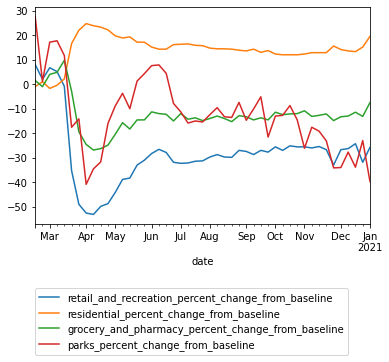

In [72]:
m_highlights_w_df.plot()
plt.legend(loc = (0., -0.6))
plt.show()

Biggest reduction in the retail/recreation sector.

In [73]:
trash_weekly_df = df3.resample("W").sum()

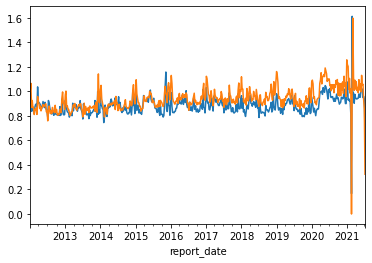

In [74]:
garb_week_df_norm = trash_weekly_df["GARBAGE COLLECTIONS"]/trash_weekly_df["GARBAGE COLLECTIONS"][start_date_model][0]
recy_week_df_norm = trash_weekly_df["RECYCLING - SINGLE STREAM"]/trash_weekly_df["RECYCLING - SINGLE STREAM"][start_date_model][0]
garb_week_df_norm.plot()
recy_week_df_norm.plot()
plt.show()

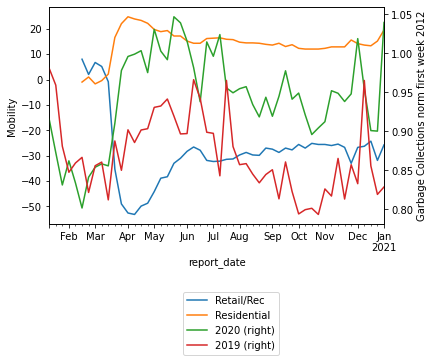

In [75]:
fig = plt.figure()

ax_1 = m_highlights_w_df["retail_and_recreation_percent_change_from_baseline"].plot(label = "Retail/Rec")
ax_1.set_ylabel('Mobility')
ax_2 = m_highlights_w_df["residential_percent_change_from_baseline"].plot(label = "Residential")

garb_week_df_2020 = garb_week_df_norm[m_highlights_w_df.index[0] + pd.Timedelta(-5, "W") :m_highlights_w_df.index[-1]]

ax_3 = garb_week_df_2020.plot(secondary_y = True, label = "2020")
ax_3.set_ylabel('Garbage Collections norm first week 2012')

garb_week_df_2019 = garb_week_df_norm['2019']
garb_week_df_2019.index = garb_week_df_2020.index

ax_4 = garb_week_df_2019.plot(secondary_y = True, label = "2019")

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc = (0.4, -0.6))
plt.show()

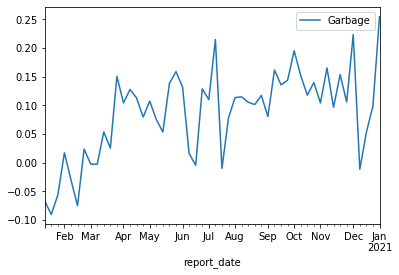

In [76]:
garbage_change = ((garb_week_df_2020 - garb_week_df_2019)/garb_week_df_2019)

garbage_change.plot(label = "Garbage")
plt.legend()
plt.show()

It seems to agree with our hypothesis but humility is due since we only have one observation. The effect is similar (slightly more pronounced) for recycling.

In [77]:
weekly_differences_mob = np.abs(m_highlights_w_df["retail_and_recreation_percent_change_from_baseline"]['2020']\
    .diff()\
    .dropna())

In [79]:
max_restriction = weekly_differences_mob[weekly_differences_mob == max(weekly_differences_mob)]
max_restriction

date
2020-03-22    34.428571
Freq: W-SUN, Name: retail_and_recreation_percent_change_from_baseline, dtype: float64

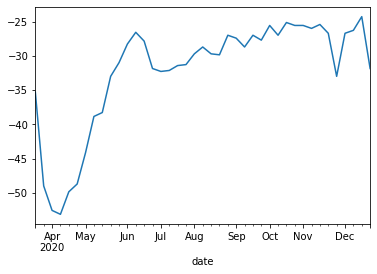

In [80]:
m_highlights_w_df["retail_and_recreation_percent_change_from_baseline"]\
    ['2020']\
    [max_restriction.index[0]:].plot()
plt.show()

This large (negative) shift in mobility was due to restrictions imposed by the city of Austin, in particular, the 17 of March ordinance requiring the closure of bars and dining areas, the 20 of March state social distancing / social gathering restrictions and the 24 of March stay at home orders. On the 28 of March, the Parks and Recreation Department closed all park amenities, aside from water fountains and restrooms. For more details, see [here](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Austin,_Texas).

## 6. Demographics analysis

Summary of main conclusions:

Waste per person reduced from 2012 until 2020 is due to the population growth being faster than that of waste volume. However, due to Covid (as we have shown before), the large increase in the amount of waste has caused the ratio to increase to levels above those of 2012. 

In [81]:
pop_data_dic = {2011: 812025, 2012 :832326, 2013: 855215, 2014: 878733, 2015: 900701, 2016: 926426, 2017: 949587, 2018: 967629,
                2019: 985504, 2020: 1006727, 2021: 1026833, 2022: 1041722, 2023: 1056827, 2024: 1070565, 2025: 1083948, 2026: 1097497,
                2030: 1153409, 2035: 1227322, 2040: 1289928} ## Population figures are of 1 April of each year, from the population PDF

Because we want to complete the year of 2021 with data, we will plug the values of 2020 in the missing values of 2021, adjusted for the level of 2021 waste.

In [82]:
monthly_total_waste_df = df3.resample("M").sum().sum(axis = 1)
extra_months = pd.Series(data = np.nan, index = pd.date_range(monthly_total_waste_df.index[-1] + pd.Timedelta(30, unit = "d"), periods = 5, freq = "M"))
complete_monthly_total_waste_df = pd.concat((monthly_total_waste_df,extra_months))

mult_fact = np.mean(monthly_total_waste_df["2021"][:6].values/monthly_total_waste_df["2020"][:6].values)

complete_monthly_total_waste_df["2021"][6:] = mult_fact*complete_monthly_total_waste_df["2020"][6:]

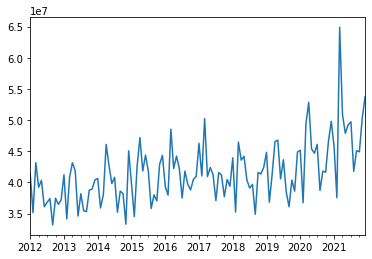

In [83]:
complete_monthly_total_waste_df.plot()
plt.show()

In [84]:
total_weight_df = pd.DataFrame(complete_monthly_total_waste_df.resample("Y").sum(), columns = ["Total Weight"])
pop_data_series = pd.Series([pop_data_dic[year] for year in range(2012,2022,1)], index = total_weight_df.index)
total_weight_df["Total Population"] = pop_data_series

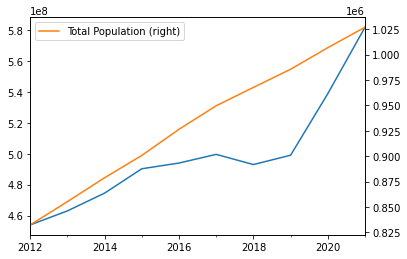

In [85]:
fig , ax = plt.subplots()
total_weight_df["Total Weight"].plot(ax = ax, label = "Total Weight")
total_weight_df["Total Population"].plot(ax = ax, secondary_y = True, label = "Total Population")
plt.legend()
plt.show()

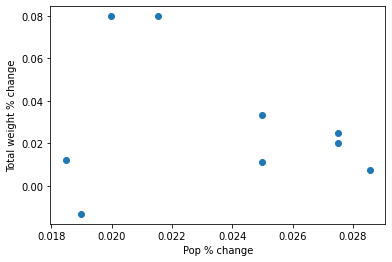

In [86]:
total_weight_df_pc_ch = total_weight_df.pct_change()
plt.scatter(x = total_weight_df_pc_ch["Total Population"] , y = total_weight_df_pc_ch["Total Weight"])
plt.xlabel("Pop % change")
plt.ylabel("Total weight % change")
plt.show()

In [87]:
total_weight_df = total_weight_df.assign(Waste_in_pounds_per_person = lambda df : df["Total Weight"]/df["Total Population"]) 

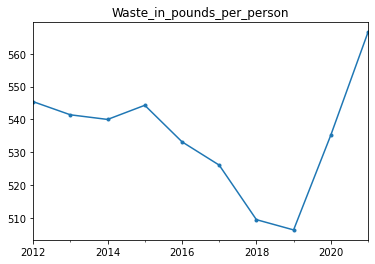

In [88]:
total_weight_df["Waste_in_pounds_per_person"].plot(marker = '.')
plt.title("Waste_in_pounds_per_person")
plt.show()

The fact that waste per person reduced from 2012 until 2020 is due to the population growth being faster than that of waste volume. However, due to Covid (as we have shown before), the large increase in the amount of waste has caused the ratio to increase to levels above those of 2012. 

This is a warning for policy makers that changes in consumer patterns can dramatically alter waste consumption and that policy proactivity is needed in order to counter the negative effects of an increased amount of waste.

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

All the websites below are from the city of Austin, Texas official webpage or its open data portal unless stated otherwise:

[Waste collection & diversion report](https://data.austintexas.gov/Utilities-and-City-Services/Waste-Collection-Diversion-Report-daily-/mbnu-4wq9)


[Curbside composting collection](https://www.austintexas.gov/composting)


[Expansion of the compositing program](https://www.austintexas.gov/news/city-expands-curbside-composting-collection-55000-new-austin-households-final-phase-expansion)


[Yard trimming collection](https://www.austintexas.gov/department/yard-trimmings-collection)


[Recycling](https://www.austintexas.gov/recycling)

[Demographics data](https://www.austintexas.gov/sites/default/files/files/Planning/Demographics/austin_forecast_2021_pubfix.pdf)

[Single-stream recycling (Wiki)](https://en.wikipedia.org/wiki/Single-stream_recycling)


[Google Mobility data (Google)](https://www.google.com/covid19/mobility/)


[TDS Landfill (Youtube)](https://www.youtube.com/watch?v=5kC026ImtmA&ab_channel=TexasDisposalSystems)

[OECD Composite Leading (Economic) Indicator](https://data.oecd.org/leadind/composite-leading-indicator-cli.htm)

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


**Ideas that we explored but did not come to fruition/deserve more investigation**:

1. The large holidays (X-mas, Thanksgiving, 4th of July) are local maxima. The city of Austin could implement targeted measures to drive more recycling rather than undifferentiated waste. This is especially relevant in the US where it is common to use disposable plates/forks&knives/cups in parties.

2. Following the above idea, check if days where the University of Texas (UT) football team plays (the stadium is in the center of Austin) lead to an increased amount of waste. This is because  American football is a huge thing in Texas, especially at the college level. Tailgating in the vicinity of the stadium, or getting friends together to party during/after the game is extremely common. Since the stadium of the University of Texas football team is in Austin, one is likely to see an increase in waste in the days in which UT plays - see here for their 2021 playing schedule. Since the 2021 season was delayed due to COVID, it is probably better to look at the 2019 season. However, we did not find any meaningful increase of waste in the data (see image below - the white squared-like shape just above *Austin* at the center of the image) partially because the area of the stadium does not appear in the waste data. If we could show that there is an increase in waste, we could target UT's management and ask them to enforce recycling policies - as providing refunds for disposable plates/cups, have UT football legends advertise this issue, etc...

3. The city of Austin has on its website *The City of Austin is committed to a zero waste goal to reduce the amount of trash sent to landfills by 90% by the year 2040*. We tried to verify this claim (because it seems unlikely to be feasable given the lack of reduction of garbage collections), but were not able to.

4. Waste hotspots (see below). There are areas of the city that produce more waste than others. With this information, policy makers could try to design targeted community programms to reduce waste.


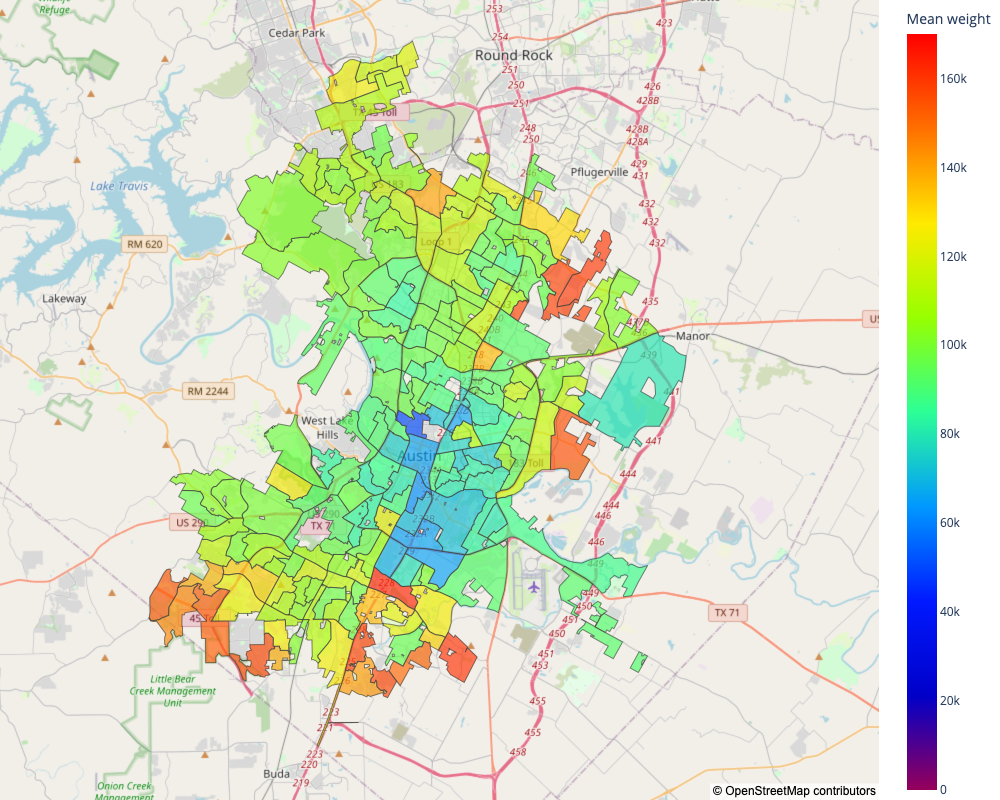